In [11]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
import numpy as np
import math
from qiskit import BasicAer, execute
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy

In [12]:
def state_prep(matrix):
    flat = np.array(matrix.flatten())
    sumsq = np.sqrt(np.sum(matrix**2))
    return flat/sumsq

In [13]:
example = np.array([3087, 906, 1405, 58])
# example = np.array([[0.4489, 0.2304, 0.2162, 0],[0.2304, 0.2518, 0.2399, 0], [0.2162, 0.2399, 0.2993, 0], [0, 0, 0, 0]])
# example = np.array([0, 1, -2, -3])
vector = state_prep(example)
display(vector)

array([0.87921268, 0.2580391 , 0.40015997, 0.01651906])

In [14]:
q=QuantumRegister(3)
c=ClassicalRegister(3)
qc=QuantumCircuit(q,c)

#initial state of the second and third qubit (eigenstate)
# state_vector=[math.sqrt(3087/(3087 + 906 + 1405 + 58)),math.sqrt(906/(3087 + 906 + 1405 + 58)),math.sqrt(1405/(3087 + 906 + 1405 + 58)),math.sqrt(58/(3087 + 906 + 1405 + 58))]
qc.initialize(vector,[q[1],q[2]])

In [15]:
vector

array([0.87921268, 0.2580391 , 0.40015997, 0.01651906])

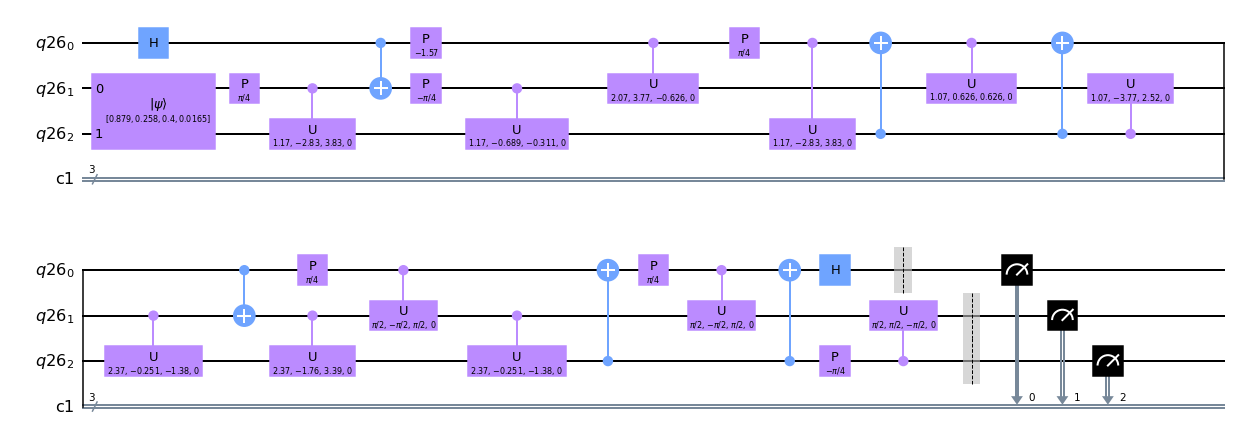

In [16]:
#preparation of the first qubits (1-bit eigenvalue estimation)
qc.h(q[0])

#controlled Urho
#cV1
qc.p(0.785398,q[1])
qc.cu(1.1747,-2.83038,3.83087,0,q[1],q[2])
#cX
qc.cx(q[0],q[1])
#cV1dag
qc.p(-0.785398,q[1])
qc.cu(1.1747,-0.689273,-0.31121,0,q[1],q[2])
#cXV2X
qc.p(-1.5708,q[0])
qc.cu(2.07033,3.76782,-0.626228,0,q[0],q[1])
#cV1
qc.p(0.785398,q[0])
qc.cu(1.1747,-2.83038,3.83087,0,q[0],q[2])
#cX
qc.cx(q[2],q[0])
#cV2Xdag
qc.cu(1.07126,0.626228,0.626228,0,q[0],q[1])
#cX
qc.cx(q[2],q[0])
#cV2X
qc.cu(1.07126,-3.76782,2.51536,0,q[2],q[1])
#cV3
qc.cu(2.3749,-0.251338,-1.38469,0,q[1],q[2])
#cX
qc.cx(q[0],q[1])
#cV3dag
qc.cu(2.3749,-1.7569,3.39293,0,q[1],q[2])
#cXvx
qc.p(1/4*np.pi,q[0])
qc.cu(1/2*np.pi,-1/2*np.pi,1/2*np.pi,0,q[0],q[1])
#cV3
qc.cu(2.3749,-0.251338,-1.38469,0,q[1],q[2])
#cX
qc.cx(q[2],q[0])
#cVxdag
qc.p(1/4*np.pi,q[0])
qc.cu(1/2*np.pi,-1/2*np.pi,1/2*np.pi,0,q[0],q[1])
#cX
qc.cx(q[2],q[0])
#cVx
qc.p(-1/4*np.pi,q[2])
qc.cu(1/2*np.pi,1/2*np.pi,-1/2*np.pi,0,q[2],q[1])

#InverseQFT
qc.h(q[0])

##meassure on basis II
#qc.h(q[1])
##meassure on basis III
#qc.h(q[2])
##meassure on basis IV
#qc.h(q[1])
#qc.h(q[2])

#projection and meassurement
qc.barrier(q[0])
qc.barrier(q[1])
qc.barrier(q[2])
qc.measure(q[0],c[0])
qc.measure(q[1],c[1])
qc.measure(q[2],c[2])
qc.draw(output='mpl')



In [17]:
#Run on qasm simulator
backend_qasm=BasicAer.get_backend('qasm_simulator')
job_qasm=execute(qc,backend_qasm,shots=8192)
result_qasm=job_qasm.result()
counts=result_qasm.get_counts(qc)
print(counts)
sim_jobID=job_qasm.job_id()
print('SIMULATION JOB ID: {}'.format(sim_jobID))
# #Run on real device
# backend_exp=IBMQ.get_backend('ibmqx2')
# backend_exp.name()
# job_exp=execute(qc,backend_exp,shots=8192)#,max_credits=3)
# job_monitor(job_exp)
# result_exp=job_exp.result()
# counts_exp = result_exp.get_counts()
# print(counts_exp)
# plot_histogram([counts_exp,counts])
# jobID=job_exp.job_id()
# print('JOB ID: {}'.format(jobID)) 
prob_values = []
upperLimit = max(counts.values())
probSum = sum(counts.values())
prob_values.append(upperLimit)
display(counts)

# display(sum(counts.values()))
# display(prob_values)

{'000': 3199, '101': 2160, '001': 1356, '010': 145, '100': 443, '110': 540, '011': 280, '111': 69}
SIMULATION JOB ID: 84a6ba74-bc26-4ab7-aa7e-9ee6b2842b6a


{'000': 3199,
 '101': 2160,
 '001': 1356,
 '010': 145,
 '100': 443,
 '110': 540,
 '011': 280,
 '111': 69}

In [18]:
def get_bounds(counts):
    sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
    so_far = 0
    used_keys = {}
    total = sum(counts.values())
    for i,(key,value) in enumerate(sorted_counts.items()):
        if so_far <= total * 0.7:
            so_far += value
            used_keys[key] = value/total
    return {"probability" : so_far / total, "keys" : used_keys}

In [19]:
get_bounds(counts)

{'probability': 0.8197021484375,
 'keys': {'000': 0.3905029296875, '101': 0.263671875, '001': 0.16552734375}}

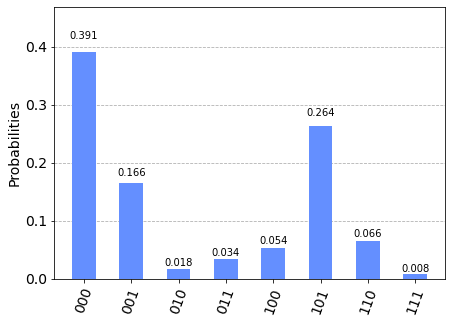

In [20]:
plot_histogram(counts)